In [5]:
# General Libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
# True Model
from scipy.integrate import odeint
from scipy.fft import fft

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras


# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler



# Plotting Libraries
import matplotlib.pylab as plt
import seaborn as sns


# My Modules
import shap as shap
from wilkeXAI.data_generator import DataGenerator
import wilkeXAI.wilke_shap as fwg
  
# Set Seaborn Theme
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)


In [6]:
def eom(u, t, params = {}):
    """
        Duffing Oscillator Equation of Motion

        ddx + delta * dx**2 + alpha * x + beta * x**3 = gamma * cos(omega * t)

        Input
        ----------
        u : vector of length 2, (x,v)
            Position and Velocity at time t
        t : float, the time t

        Parameters
        ----------
        alpha : float, linear stiffness
        beta  : float, non linearity in the restoring force
        gamma : float, amplitude of the periodic driving force
        delta : float, amount of damping
        omega : float, angular frequency of the periodic driving force

        Returns
        ----------
        [dx,ddx] : Tuple, Time derivatives of 
                    position and velocity at time t

    """
    x, dx = u[0], u[1]
    ddx = (0.37 * np.cos(1.2 * t) - (-1 * dx + (-1) * x + 1 * x**3))

    return [dx,ddx]

In [7]:
def generate(num_samples = int(5e1), delay=3, samples=10, end_time=100):
        """
            Generates training samples using scipy.integrate.odeint
            to calculate the temporal evolution of a Duffing system.
    
            Samples randomly from x0 in [-2,2], v0 in [-1,1].
    
            For each set of initial conditions we generate a trajectory.
            The trajectory is randomly sampled to generate training
            pairs: X = (x0,v0,t), y = (xt,vt)
    
            Input
            ----------
            num_samples : int, number of training
                            samples to be generated
    
            Returns
            ----------
            X : array((num_samples,3)), each entry in the array
                is a training sample (x0,v0,t)
            y : array((num_samples,2)), each entry in the array
                is a target sample (xt,vt)
        """
        
        #Define bounds of the sampling
        x_min = -2
        x_max = 2
        v_min = -2
        v_max = 2
        #Initialise the output arrays
        parameter_length = 1
        labels = ['xt','vt']
        features = ['x0','v0','t','rand']
        X = np.empty((num_samples*(samples-delay), len(features)))
        y = np.empty((num_samples*(samples-delay), len(labels)))
        #Define the t_range to draw from
        t_range = np.linspace(0, end_time, 100, endpoint=False)
        t_vals = [int(100/samples*i) for i in range(samples)][delay:]
        #Generate num_samples samples
        for i in tqdm(range(num_samples), desc="Generating Data…", ascii=False, ncols=75):
            #Generate random starting positions
            x0 = (x_max - x_min) * np.random.random_sample() + x_min
            v0 = (v_max - v_min) * np.random.random_sample() + v_min 
            #Generate a trajectory
            trajectory = odeint(eom, [x0,v0], t_range)
            for j, t_ind in enumerate(t_vals):
                X[j+i*(samples-delay),:] = [x0, v0, t_range[t_ind], np.random.sample()]
                y[j+i*(samples-delay),:] = trajectory[t_ind,:]      
                                    
        X_df = pd.DataFrame(X, columns = features)
        y_df = pd.DataFrame(y, columns = labels)
        return X_df, y_df, features, labels

In [8]:
suffix = "negative_damp"

In [9]:
X, y, features, labels = generate(num_samples = int(1e3))

Generating Data…: 100%|████████████████| 1000/1000 [00:17<00:00, 57.36it/s]


In [10]:
scaler = MinMaxScaler(feature_range=[-2,2])

X_data = pd.DataFrame(scaler.fit_transform(X), columns=features)

In [11]:
def true_predict(X):
    if type(X) == pd.core.frame.DataFrame:
        X = pd.DataFrame(scaler.inverse_transform(X.values), columns=X.columns)
    elif type(X) == np.ndarray:
        X = pd.DataFrame(scaler.inverse_transform(X), columns=features)
    
    y = np.ones((np.shape(X)[0], 2))
    for i in range(0,np.shape(X)[0]):
        t_range = np.linspace(0, X['t'].iloc[i], 100, endpoint=True)
        y[i,:] = odeint(eom, [X['x0'].iloc[i], X['v0'].iloc[i]], t_range)[-1]
    return y   

In [12]:
class AnalyticExplainer():
    """
        Pretty Brute force numerical gradient calculation for
        explainability of a known function
    """
    def __init__(self, f, features, labels,  h=0.01):
        """
            Initialises with some configurations for the gradient calculation
            as well as the function being differentiated.
            
            Inputs
            --------
            f : function that takes a pandas.DataFrame and outputs a 2d np.array.
            features : list of features in the pd.DataFrame for which we are to 
                differentiate f.
            labels : list of features in the np.array.
        """
        self.f = f
        self.features = features
        self.labels = labels
        self.h = h
        
    def gradient(self, X_val, feature):
        """
            Numerical Gradient Calculation by way of a CFD method.
            Inputs
            --------
            X_val : pandas.DataFrame with columns: features and values at
                which we want to take the numerical gradient.
            feature : feature by which we want to differentiate.
        """
        X_prime_plus = X_val.copy()
        X_prime_plus.loc[:,(feature)] = X_prime_plus[feature] + self.h
        X_prime_minus = X_val.copy()
        X_prime_minus.loc[:,(feature)] = X_prime_minus[feature] - self.h
        
        grad = (self.f(X_prime_plus) - self.f(X_prime_minus))/(2*self.h)
        
        return grad
    def feature_att(self, X):
        """
            Calculates the Gradients for all Entries in X, for each
            feature and label combination.
            
            Inputs
            --------
            X : pandas.DataFrame with columns:features and values at
                which we want to differentiate.
            Returns
            --------
            self.__atts : [np.array[...],np.array[...]] of gradients at
                each of the input points. Calculated for each label and stacked.
        """
        first_run = True
        for i,__label in enumerate(self.labels):
            grads = self.gradient(X, self.features[0])[:,i]
            for __feat in self.features[1:]:
                grads = np.vstack((grads,self.gradient(X, __feat)[:,i]))
            if first_run:
                self.__atts = grads.transpose()
                first_run = False
            else:
                self.__atts = [self.__atts, grads.transpose()]
                        
        return self.__atts
    

In [13]:
background = shap.sample(X_data, 100)

In [14]:
shap_explainer = shap.KernelExplainer(true_predict, background)

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


In [15]:
X_sorted = X_data.sort_values(by=['x0'])

choice = X_sorted.iloc[np.sort(np.random.choice(X_sorted.shape[0], 100, replace =False))]

In [16]:
choice

,x0,v0,t,rand
586,-1.997559,0.470868,1.333333,1.377412
1523,-1.980138,-0.822683,0.666667,1.199415
6282,-1.950490,1.897072,0.000000,-0.054612
1870,-1.946890,-1.477562,-1.333333,-1.213328
862,-1.929537,1.406998,-1.333333,-1.217816
...,...,...,...,...
4338,1.773908,-0.487539,1.333333,-0.587234
1847,1.775573,-0.256816,2.000000,1.845101
5657,1.833866,-0.105400,-1.333333,-1.072445
5992,1.868160,0.091967,-2.000000,-1.368276


In [17]:
X_shap_values = shap_explainer.shap_values(choice)

  0%|          | 0/100 [00:00<?, ?it/s]

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 

In [18]:
lime_explainer = shap.other.LimeTabular(true_predict, background, mode="regression")

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


In [19]:
X_lime_values = lime_explainer.attributions(choice)

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
overflow encountered in square
overflow encountered in square
invalid value encountered in true_divide
overflow encountered in square
overflow encountered in square
invalid value encountered in true_divide
overflow encountered in square
overflow encountered in square
invalid value encountered in true_divide
overflow encountered in square
overflow encountered in square
invalid value encountered in true_divide
overflow encountered in square
overflow encountered in square
invalid value encountered in true_divide
overflow encountered in square
overflow encountered in square
invalid value encountered in true_divide
overflow encountered in square
overflow encountered in square
invalid value encountered in true_divide
overflow encountered in square
overflow encountered in square
invalid value encountered in true_divide
overflow encountered in square
overflow encountered in square

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 

In [20]:
anal_explainer = AnalyticExplainer(true_predict, ['x0','v0','t','rand'], ['xt', 'vt'],  h=0.01)

In [21]:
X_anal_values = anal_explainer.feature_att(choice)

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 

Text(0, 0.5, 'Feature Contribution [ ]')

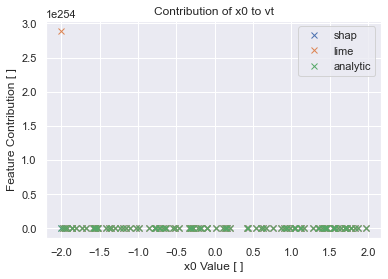

In [22]:
plt.plot(choice['x0'], X_shap_values[1][:,0],' x', label = 'shap')
plt.plot(choice['x0'], X_lime_values[1][:,0],' x', label = 'lime')
plt.plot(choice['x0'], X_anal_values[1][:,0],' x', label = 'analytic')
plt.legend()
plt.title('Contribution of x0 to vt')
plt.xlabel('x0 Value [ ]')
plt.ylabel('Feature Contribution [ ]')



Text(0, 0.5, 'Feature Contribution [ ]')

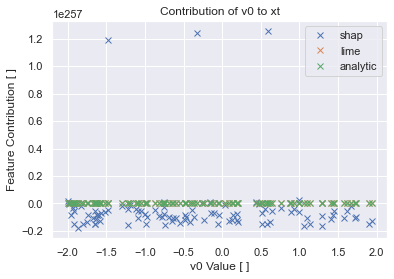

In [23]:
plt.plot(choice['v0'], X_shap_values[0][:,1],' x', label = 'shap')
plt.plot(choice['v0'], X_lime_values[0][:,1],' x', label = 'lime')
plt.plot(choice['v0'], X_anal_values[0][:,1],' x', label = 'analytic')
plt.legend()
plt.title('Contribution of v0 to xt')
plt.xlabel('v0 Value [ ]')
plt.ylabel('Feature Contribution [ ]')

Text(0, 0.5, 'Feature Contribution [ ]')

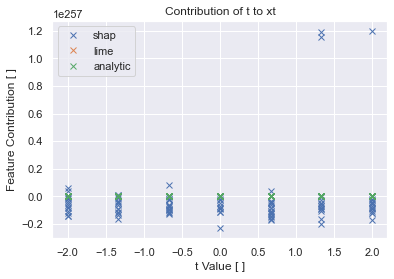

In [24]:
plt.plot(choice['t'], X_shap_values[0][:,2],' x', label = 'shap')
plt.plot(choice['t'], X_lime_values[0][:,2],' x', label = 'lime')
plt.plot(choice['t'], X_anal_values[0][:,2],' x', label = 'analytic')

plt.legend()
plt.title('Contribution of t to xt')
plt.xlabel('t Value [ ]')
plt.ylabel('Feature Contribution [ ]')

Text(0, 0.5, 'Feature Contribution [ ]')

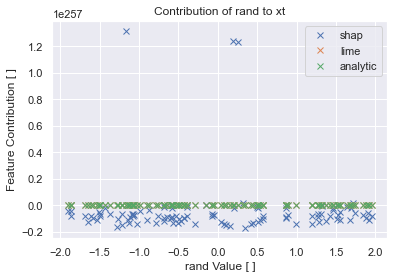

In [25]:
plt.plot(choice['rand'], X_shap_values[0][:,3],' x', label = 'shap')
plt.plot(choice['rand'], X_lime_values[0][:,3],' x', label = 'lime')
plt.plot(choice['rand'], X_anal_values[0][:,3],' x', label = 'analytic')

plt.legend()
plt.title('Contribution of rand to xt')
plt.xlabel('rand Value [ ]')
plt.ylabel('Feature Contribution [ ]')

Text(0, 0.5, 'Feature Contribution [ ]')

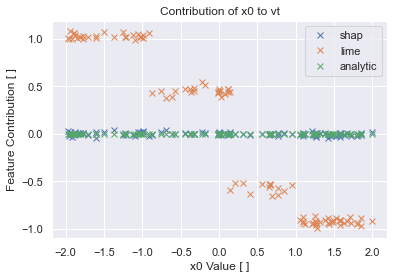

In [79]:
plt.plot(choice['x0'], X_shap_values[1][:,0],' x', label = 'shap')
plt.plot(choice['x0'], X_lime_values[1][:,0],' x', label = 'lime')
plt.plot(choice['x0'], X_anal_values[1][:,0],' x', label = 'analytic')
plt.legend()
plt.title('Contribution of x0 to vt')
plt.xlabel('x0 Value [ ]')
plt.ylabel('Feature Contribution [ ]')


Text(0, 0.5, 'Feature Contribution [ ]')

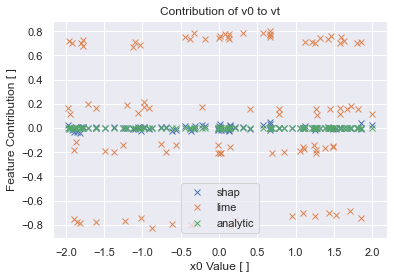

In [80]:
plt.plot(choice['x0'], X_shap_values[1][:,1],' x', label = 'shap')
plt.plot(choice['x0'], X_lime_values[1][:,1],' x', label = 'lime')
plt.plot(choice['x0'], X_anal_values[1][:,1],' x', label = 'analytic')
plt.legend()
plt.title('Contribution of v0 to vt')
plt.xlabel('x0 Value [ ]')
plt.ylabel('Feature Contribution [ ]')


Text(0, 0.5, 'Feature Contribution [ ]')

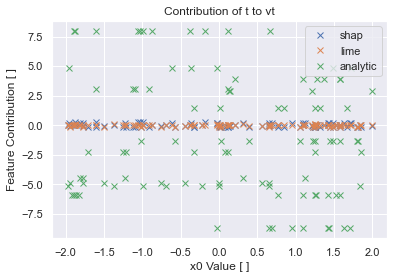

In [81]:
plt.plot(choice['x0'], X_shap_values[1][:,2],' x', label = 'shap')
plt.plot(choice['x0'], X_lime_values[1][:,2],' x', label = 'lime')
plt.plot(choice['x0'], X_anal_values[1][:,2],' x', label = 'analytic')
plt.legend()
plt.title('Contribution of t to vt')
plt.xlabel('x0 Value [ ]')
plt.ylabel('Feature Contribution [ ]')

Text(0, 0.5, 'Feature Contribution [ ]')

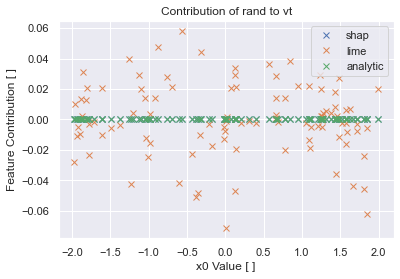

In [82]:
plt.plot(choice['x0'], X_shap_values[1][:,3],' x', label = 'shap')
plt.plot(choice['x0'], X_lime_values[1][:,3],' x', label = 'lime')
plt.plot(choice['x0'], X_anal_values[1][:,3],' x', label = 'analytic')
plt.legend()
plt.title('Contribution of rand to vt')
plt.xlabel('x0 Value [ ]')
plt.ylabel('Feature Contribution [ ]')


In [ ]:
def gridded_data(feature='x0', X, features = ['x0','v0','t','rand']):
    feat_min = min(X[feature])
    feat_max = max(X[feature])
    
    feat_range = np.linspace(feat_min, feat_max, 100)
    data = np.empty((100,len(features)))
    for k in features:
        data[:,k] = np.ones((100,1))*np.mean(X[k])
    
        
    data = pd.DataFrame(data, columns = features)
    for i, val in enumerate(feat_range):
        data[feature][i] = val
        
    return data


In [47]:
shap_exp.eval_explainer()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,,,,x0,v0,t,rand,alpha,beta,gamma,delta,omega
num,feature,contribution,model,,,,,,,,,
0,x0,xt,ml,0.974175,0.009153,0.319542,0.0,0.0,0.0,0.0,0.0,0.0
1,x0,xt,ml,0.881571,0.094095,0.231594,0.0,0.0,0.0,0.0,0.0,0.0
2,x0,xt,ml,0.886235,0.094706,0.283503,0.0,0.0,0.0,0.0,0.0,0.0
3,x0,xt,ml,0.975932,-0.000095,0.231423,0.0,0.0,0.0,0.0,0.0,0.0
4,x0,xt,ml,-0.427818,-0.482664,0.268088,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,omega,vt,ml,0.017997,0.017619,-0.114530,0.0,0.0,0.0,0.0,0.0,0.0
96,omega,vt,ml,0.021289,-0.000377,0.245801,0.0,0.0,0.0,0.0,0.0,0.0
97,omega,vt,ml,0.013871,0.029744,0.177137,0.0,0.0,0.0,0.0,0.0,0.0


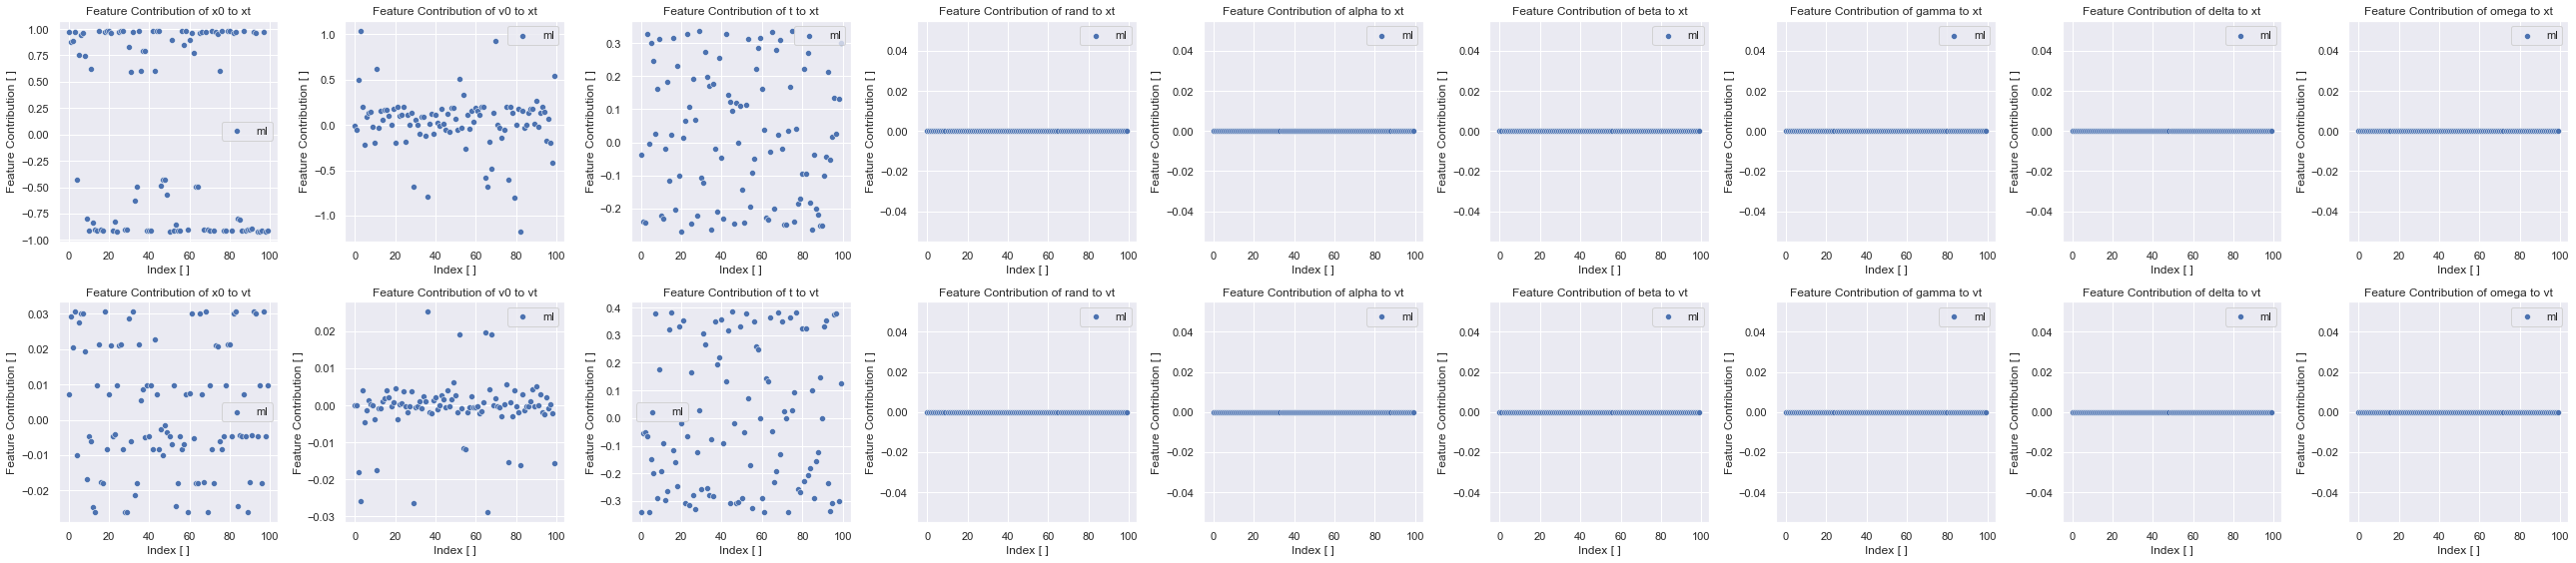

In [48]:
shap_exp.exp_plot()

In [ ]:
lime_exp = fwg.wilke_explainer(models, X_exp, X_exp, y, suffix = suffix, data_tol=0.1, num_vals=100, 
                 explainer_type='lime', background_resolution=100, tolerance=2)

lime_exp.eval_explainer()

lime_exp.exp_plot()

In [ ]:
anal_exp = fwg.wilke_explainer(models, X_exp, X_exp, y, suffix = suffix, data_tol=0.1, num_vals=100, 
                 explainer_type='analytic', background_resolution=100, tolerance=2)

anal_exp.eval_explainer()

anal_exp.exp_plot()

In [ ]:
def agg_plot(agg_vals, test_labels, explainer_type='shap', models=models):
    """
        Plotting routine to visualise the aggregated feature importance.
    """
    f, axs = plt.subplots(len(models), test_labels.shape[1], 
                          figsize=(6*test_labels.shape[1], 4*len(models)), 
                          gridspec_kw=dict(width_ratios=4*np.ones((test_labels.shape[1]))))

    for i, __model in enumerate(models):
        for j, __contribution in enumerate(test_labels):
            sns.barplot(data = agg_vals.xs((__contribution, __model), level=('contribution', 'model')),
                x = agg_vals.xs((__contribution, __model), level=('contribution', 'model')).index,
                y = 'contrib', label = __model, ax=axs[i,j])
            axs[i,j].set_title(r"Aggregate Feature Contribution to "+__contribution+" in the "+__model+" Model")
            axs[i,j].set_ylabel('Feature Contribution [ ]')

    f.tight_layout()
    f.savefig("Images/"+explainer_type+"_aggregated"+suffix+".svg", dpi='figure')

In [ ]:
anal_agg = anal_agg.set_index(['feature', 'contribution', 'model'])

In [ ]:
agg_plot(anal_agg, y_test, explainer_type='analytic')

In [ ]:
def exp_plot(feature_attributions, test_labels, test_data, models=models, explainer_type='shap'):
    """
        Plotting routine to visualise the explainers' results. Plots individual
        feature contribution for each model and each feature.
    """
    f, axs = plt.subplots(test_labels.shape[1], test_data.shape[1], 
                          figsize=(4*test_data.shape[1], 8), 
                          gridspec_kw=dict(width_ratios=4*np.ones((test_data.shape[1]))))

    for i, __feature in enumerate(test_data.columns):
        for j, __contribution in enumerate(test_labels.columns):
            for __model in models:
                sns.scatterplot(data = feature_attributions.xs((__feature, __contribution, __model), 
                                                  level=('feature', 'contribution', 'model')), 
                                x = feature_attributions.xs((__feature, __contribution, 'true'), 
                                               level=('feature', 'contribution', 'model')).index,
                                y = feature_attributions.xs((__feature, __contribution, __model), 
                                             level=('feature', 'contribution', 'model'))[__feature],
                                label = __model, ax=axs[j,i])  

            axs[j,i].set_title(r"Feature Contribution of "+__feature+" to "+__contribution+"")
            axs[j,i].set_xlabel('Index [ ]')
            axs[j,i].set_ylabel('Feature Contribution [ ]')

    f.tight_layout()

    f.savefig("Images/"+explainer_type+"_summary"+suffix+"_kernel_good.svg", dpi='figure')

In [ ]:
exp_plot(lime_indiv, y_test, X_test, models=models, explainer_type='lime')

In [2]:
"""
Define and Machine Learning Model
"""

def MLModel():
    opt = Adam(learning_rate=0.001, beta_1=0.7)
    loss='mse'
    model = Sequential([
        layers.Flatten(),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='sigmoid'),
        layers.Dense(32, activation='tanh'),
        layers.Dense(2)            
    ])
    model.compile(optimizer=opt, loss=loss)
    return model


In [3]:
suffix = "Run_1"
generator = DataGenerator()
# Generate the data
X_train, y_train = generator.generate(num_samples=int(1e4))
X_test, y_test = generator.generate(num_samples=int(1e3))

NameError: name 'DataGenerator' is not defined

In [ ]:
X_train.loc[:,'x0':'t']

In [ ]:
scaler = StandardScaler()

scaler.fit(X_train.loc[:,'x0':'t'].values)
scaler.transform(X_train.loc[:,'x0':'t'].values, copy=False)
scaler.transform(X_test.loc[:,'x0':'t'].values, copy = False)

In [ ]:
X_test.iloc[:,:3]

In [ ]:
if type(X_test.values) == np.ndarray:
    print('bleh')

In [ ]:
model = MLModel()
true_model = fwg.TrueModel(scaler, X_test)

In [ ]:
# Train Network
# Model Weights Path
checkpoint_path = "Networks//training//"+suffix+"cp1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks = [cp_callback,
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)]


history=model.fit(X_train, y_train, steps_per_epoch=None, epochs=3, 
                  validation_split=0.2, batch_size=20364, shuffle=True, callbacks=callbacks, verbose=2)

In [ ]:
X_test.columns[:4]

In [ ]:
models = {'ml': model, 
         'true': true_model}
       
for exp_type in ['shap', 'lime', 'analytic']:
    explainer_curr = fwg.wilke_explainer(models, X_train, X_test, y_test, explainer_type=exp_type, tolerance = 1)
    explainer_curr.eval_explainer().to_csv("Results/"+exp_type+"/individual/"+suffix+".csv")
    explainer_curr.aggregate().to_csv("Results/"+exp_type+"/aggregate/"+suffix+".csv")

In [ ]:
explainer_test = fwg.wilke_explainer(models, X_train, X_test, y_test, explainer_type='shap', tolerance = 0.1)

In [ ]:
choose_vals(0,9)

In [ ]:
def choose_vals(i, num_features):
        """
            Chooses the data points on which the explainer will be evaluated for
            a given feature. First, removes any points where the prediction is
            further than tolerance from the true value. Second, takes values in
            a band of thickness tol around 0 for all features not currently being
            evaluated on. Third, chooses a random subset of length num_vals of 
            these values. This function should never be called outside of this class.
            
            Parameters
            ----------
            i : int, index of the feature being explained
            feature : str, the feature being explained
            num_features : the total number of features
            
            Returns
            ----------
            data_arr : pandas.DataFrame, array of the chosen values.
        """
        vals = np.abs(np.linalg.norm((models['ml']).predict(X_test), axis=1) - 
                      np.linalg.norm(y_test, axis=1))
        data_arr = X_test.iloc[np.where(vals < 0.1)]
        where__ = np.ones_like(data_arr.values[:,i], dtype=bool)
        for j in range(1,num_features):
            where__ = np.multiply(where__, np.abs(data_arr.values[:,(i + j)%num_features])<self.tol)
        return where__
    

In [ ]:
def choose_data(i, num_features):
        """
            Chooses the data points on which the explainer will be evaluated for
            a given feature. First, removes any points where the prediction is
            further than tolerance from the true value. Second, takes values in
            a band of thickness tol around 0 for all features not currently being
            evaluated on. Third, chooses a random subset of length num_vals of 
            these values. This function should never be called outside of this class.
            
            Parameters
            ----------
            i : int, index of the feature being explained
            feature : str, the feature being explained
            num_features : the total number of features
            
            Returns
            ----------
            data_arr : pandas.DataFrame, array of the chosen values.
        """
        vals = np.abs(np.linalg.norm((models['ml']).predict(X_test), axis=1) - 
                      np.linalg.norm(y_test, axis=1))
        
        print(vals)
        data_arr = self.test_data.iloc[np.where(vals < self.tolerance)]
        where__ = np.ones_like(data_arr.values[:,i], dtype=bool)
        for j in range(1,num_features):
            where__ = np.multiply(where__, np.abs(data_arr.values[:,(i + j)%num_features])<self.tol)
        data_arr = data_arr.iloc[where__]
        data_arr = data_arr.iloc[np.sort(
            np.random.choice(data_arr.shape[0], np.min([self.num_vals, data_arr.shape[0]]), replace=False))]
        return data_arr

In [ ]:
where__ = np.ones_like(data_arr.values[:,i], dtype=bool)

In [ ]:
params = {'alpha' : [-1],'beta' : [1], 'gamma' :[0.37], 'delta' : [1], 'omega' : [1.2]}

In [ ]:
for beta in params['gamma']:
    print(beta)

In [ ]:
X_test.set_index(['alpha', 'beta', 'gamma', 'delta', 'omega'])

In [ ]:
X_test = scaler.inverse_transform(X_test)

In [ ]:
X_test